In [8]:
def plot_shifted_spectrum(
    cube_file, v1, v2, x1, x2, y1, y2, target_freq_GHz
):
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits

    target_freq_Hz = target_freq_GHz * 1e9
    c_kms = 299792.458

    # Read data
    data = fits.getdata(cube_file)[0]  # shape: (freq, y, x)
    header = fits.getheader(cube_file)
    subcube = data[v1:v2, y1:y2, x1:x2]

    # Prepare channel and velocity axes
    CRVAL3 = header['CRVAL3']
    CDELT3 = header['CDELT3']
    CRPIX3 = header['CRPIX3']
    RESTFREQ = header['RESTFREQ']
    N_full = header['NAXIS3']

    chan_all = np.arange(N_full)
    velo_all = CRVAL3 + (chan_all + 1 - CRPIX3) * CDELT3  # m/s
    velo_all_kms = velo_all / 1e3

    # Doppler: velocity → frequency
    freq_all_Hz = RESTFREQ * (1 - velo_all_kms / c_kms)
    freq_all_GHz = freq_all_Hz / 1e9

    # Crop the desired range
    velo = velo_all_kms[v1:v2]
    freq = freq_all_GHz[v1:v2]

    # Spectrum averaging
    spectrum = subcube.mean(axis=(1, 2))

    # Find the channel corresponding to the target frequency
    diff = np.abs(freq_all_Hz - target_freq_Hz)
    target_index = np.argmin(diff)
    target_velocity = velo_all_kms[target_index]
    print(f"Frequency {target_freq_GHz:.6f} GHz corresponds to channel: {target_index}")
    print(f"target velocity = {target_velocity:.2f} km/s")

    # Plot original spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(velo, spectrum, label='Averaged Spectrum', color='black')
    plt.axvline(target_velocity, color='orange', linestyle='--', label=f'{target_freq_GHz:.3f} GHz')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f"Spectrum with Marked Frequency: {target_freq_GHz:.3f} GHz")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Frequency 217.238530 GHz corresponds to channel: 783
target velocity = -185.10 km/s


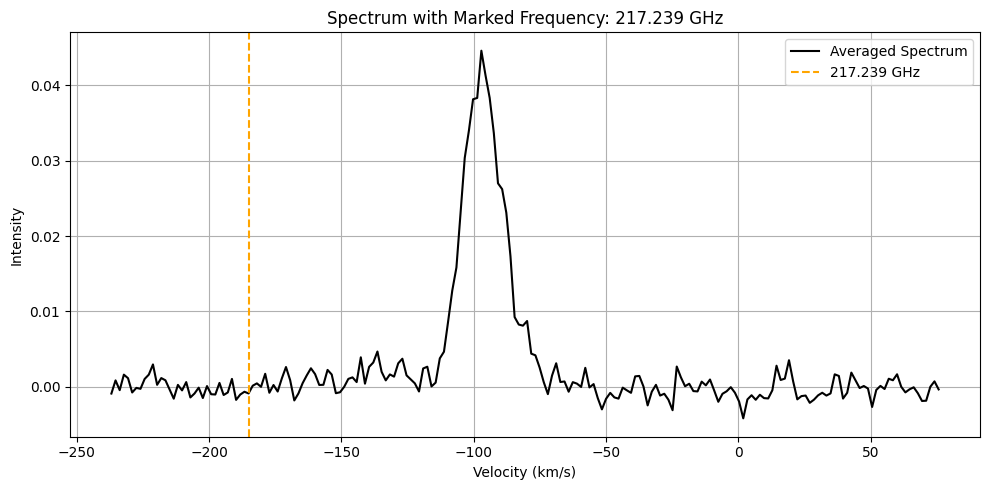

In [ ]:
plot_shifted_spectrum(
    cube_file="/Users/ccc/Desktop/research/baobab/ALMA_project/datacubes/spw0.fits",
      v1=750, v2=950, x1=235, x2=240, y1=95, y2=100, target_freq_GHz=217.238530  #SIO:217.1049
)
